
# PSB Bank Product 

In [1]:

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import datetime


In [ ]:

with open('../psb_products_updated.json', 'r', encoding='utf-8') as f:
    products_data = json.load(f)

products_df = pd.DataFrame(products_data)
print(f"Loaded {len(products_df)} products.")
products_df.head()

Loaded 71 products.


,product_name,product_type,currency,rate,amount_min,amount_max,term,fees,bonuses,requirements,additional_terms,extra_features,data_actuality,source_url
0,Кредит оборонной промышленности и военнослужащих,loan,RUB,27.9-39.9%,50000,5000000,1-7 лет,None,None,Возраст 21-65 лет; гражданство РФ; постоянная ...,Разрешено досрочное погашение; решение за 1 час,[],08.11.2025,https://www.psbank.ru/personal/loans/creditaction
1,Кредит «На любые цели»,loan,RUB,от 27.9%,100000,5000000,12-84 месяца,None,None,Возраст 21-65 лет; российское гражданство; пос...,Досрочное погашение без штрафа,[],08.11.2025,https://www.psbank.ru/personal/loans/specialpu...
2,Кредит «Рефинансирование»,loan,RUB,от 27.9%,100000,5000000,1-7 лет,None,None,Возраст 21-65 лет; российское гражданство; пос...,Досрочное погашение без штрафа,[],08.11.2025,https://www.psbank.ru/personal/loans/refinancing
3,Кредит «Турбоденьги»,loan,RUB,45.9%,10000,100000,1-12 месяцев,None,None,Возраст 23-65 лет; гражданство РФ; паспорт; по...,"Решение за 1 час; штраф за просрочку 0,06% в д...",[],08.11.2025,https://www.psbank.ru/personal/loans/turbomoney
4,Дебетовая карта «Твой Cashback»,debit_card,RUB,None,None,None,None,0 руб. за обслуживание; SMS-уведомления 99 руб...,Кэшбэк до 5% по выбранным трем категориям при ...,Возраст от 18 лет; паспорт; постоянная регистр...,Лимит снятия 300 тыс. руб./день и 600 тыс. руб...,[],09.10.2025,https://www.psbank.ru/personal/debetcards/your...


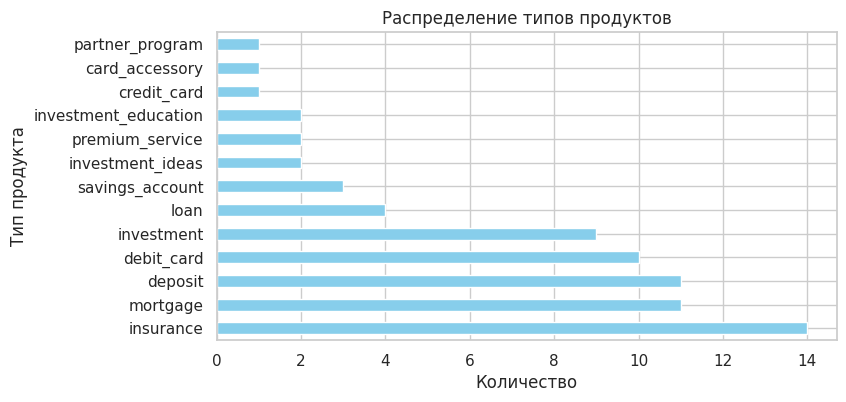

rate_min                        amount_min_num  \
                        count       mean   min   max          count   
product_type                                                          
card_accessory              0        NaN   NaN   NaN              0   
credit_card                 0        NaN   NaN   NaN              1   
debit_card                  0        NaN   NaN   NaN              0   
deposit                    11  12.972727   3.5  17.0             11   
insurance                   0        NaN   NaN   NaN              0   
investment                  0        NaN   NaN   NaN              0   
investment_education        0        NaN   NaN   NaN              0   
investment_ideas            0        NaN   NaN   NaN              0   
loan                        4  32.400000  27.9  45.9              4   
mortgage                    0        NaN   NaN   NaN              0   
partner_program             0        NaN   NaN   NaN              0   
premium_service             0        NaN   NaN   NaN              0   
savings_account             1  10.000000  10.0  10.0              3   

                                                       amount_max_num  \
                              mean       min       max          count   
product_type                                                            
card_accessory                 NaN       NaN       NaN              0   
credit_card           10000.000000  10000.00   10000.0              1   
debit_card                     NaN       NaN       NaN              0   
deposit               46363.728182      0.01  100000.0              1   
insurance                      NaN       NaN       NaN              0   
investment                     NaN       NaN       NaN              0   
investment_education           NaN       NaN       NaN              0   
investment_ideas               NaN       NaN       NaN              0   
loan                  65000.000000  10000.00  100000.0              4   
mortgage                       NaN       NaN       NaN              0   
partner_program                NaN       NaN       NaN              0   
premium_service                NaN       NaN       NaN              0   
savings_account           1.000000      1.00       1.0              0   

                                                      
                           mean       min        max  
product_type                                          
card_accessory              NaN       NaN        NaN  
credit_card            600000.0  600000.0   600000.0  
debit_card                  NaN       NaN        NaN  
deposit                 50000.0   50000.0    50000.0  
insurance                   NaN       NaN        NaN  
investment                  NaN       NaN        NaN  
investment_education        NaN       NaN        NaN  
investment_ideas            NaN       NaN        NaN  
loan                  3775000.0  100000.0  5000000.0  
mortgage                    NaN       NaN        NaN  
partner_program             NaN       NaN        NaN  
premium_service             NaN       NaN        NaN  
savings_account             NaN       NaN        NaN

In [ ]:
product_counts = products_df['product_type'].value_counts()
plt.figure(figsize=(8, 4))
product_counts.plot(kind='barh', color='skyblue')
plt.title('Распределение типов продуктов')
plt.xlabel('Количество')
plt.ylabel('Тип продукта')
plt.show()


def parse_rate(rate_str):
    if rate_str is None or pd.isna(rate_str):
        return np.nan
    s = rate_str.replace('%', '').replace(',', '.')
    if '-' in s:
        try:
            return float(s.split('-')[0].replace('от', '').strip())
        except ValueError:
            return np.nan
    try:
        return float(s.replace('от', '').replace('до', '').strip())
    except ValueError:
        return np.nan

products_df['rate_min'] = products_df['rate'].apply(parse_rate)
products_df['amount_min_num'] = pd.to_numeric(products_df['amount_min'], errors='coerce')
products_df['amount_max_num'] = pd.to_numeric(products_df['amount_max'], errors='coerce')

numeric_summary = products_df.groupby('product_type')[['rate_min','amount_min_num','amount_max_num']].agg(['count','mean','min','max'])
numeric_summary
